# **Deep Learning Project - Pothole detection** <br/>
# **Model Hyperparameter Search**
**Data Science and Advanced Analytics with a specialization in Data Science**<br/>
**NOVA IMS**<br/> 
Authors of this notebook: <br/>
* Mafalda Paço (20220619@novaims.unl.pt)<br/>
* Mª Margarida Graça (20220602@novaims.unl.pt)<br/>
* Marta Dinis (20220611@novaims.unl.pt)<br/>
* Nuno Dias (20220603@novaims.unl.pt)<br/>
* Patrícia Morais (20220638@novaims.unl.pt)<br/>


## References
1. [Hyperparameter Tuning in Keras: TensorFlow 2: With Keras Tuner: RandomSearch, Hyperband, BayesianOptimization](https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f)


## Ready to use Dataset
https://drive.google.com/file/d/1KE507iE7Hwb7TiJINnvMYCXNIGrEgPvt/view?usp=share_link

## **Summary**

In this notebook, we found the best parameter combination to try and increase the performance of the best model achieved in 'HandCraft' notebook.
We did that by using RandomSearch to perform the needed calculations.

## **Data Import**

Necessary library imports.

In [ ]:
!pip install -q -U keras-tuner

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import time
import shutil
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics
from kerastuner import RandomSearch


from kerastuner.tuners import Hyperband

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 4.9 MB/s eta 0:00:00


<ipython-input-1-c282daa712f6>:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


Connection to the Data Source. 

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/DL/Project/"
main_folder, training_folder, testing_folder = "DATA/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'DATA.zip', 'DATA.zip')
    # Extract files
    zip_ = zipfile.ZipFile('DATA.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 3.516 seconds


Definition of a list of parameters for the  function.

In [ ]:
image_size=(128, 128) 
crop_to_aspect_ratio=True 
color_mode='rgb'
batch_size=64
label_mode="binary"
validation_split=0.2
shuffle=True
seed=0

Loads the training data using the function and does an automatic split between training and validation data via validation_split, saving 20% for Validation.

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

Found 1436 files belonging to 2 classes.
Using 1149 files for training.
Using 287 files for validation.


Loads the testing data using the function.

In [ ]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 16 files belonging to 2 classes.


In [ ]:
input_shape = tuple(iter(ds_train).next()[0].shape)
input_shape

(64, 128, 128, 3)

## **Functions**

We defined a model based on our best one, from de 'Hand_Craft' notebook, to test some combination of different values for the parameters.

In [ ]:
def build_and_train_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape[1:]))

    # Convolutional layers
    for i in range(hp.Int('num_conv_layers', min_value=2, max_value=4, step=1)):
        model.add(tf.keras.layers.Conv2D(filters=hp.Choice(f'filters_layer_{i}', values=[32, 64, 128]),
                                         kernel_size=3,
                                         padding='same',
                                         activation='relu',
                                         kernel_initializer=initializers.GlorotNormal(seed=0)))
        model.add(tf.keras.layers.BatchNormalization())

        model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

        # Add dropout layer with 3 choices
        dropout_rate = hp.Choice(f'dropout_rate_{i}', values=[0.0, 0.15, 0.3])
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate, seed=0))

    # Flatten and fully connected layers
    model.add(tf.keras.layers.GlobalMaxPooling2D())
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid',
                                    kernel_initializer=initializers.GlorotNormal(seed=0),
                                    kernel_regularizer=regularizers.l2(0.01)))

    use_exp_decay = hp.Boolean('use_exp_decay')
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    if use_exp_decay:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=1000,
            decay_rate=0.96,
            staircase=True)
    else:
        lr_schedule = learning_rate

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
                  loss='binary_crossentropy',
                  metrics=[metrics.BinaryAccuracy(name='accuracy'),
                           metrics.AUC(name='AUROC')])
    return model

For this Random Search, we will test different values for the following parameters:
*   number of convolutional layers
*   number of filters of the convolutional layers
*   Dropout rate
*   learning rate
*   the use of Exponential Decay

We didn't use GridSearch given that we have a lot of possible values, so it would exceed our computational capacity.Instead, we use Random Search to find the best parameters combination of the trials.

In [ ]:
tunerRS = RandomSearch(
    build_and_train_model,
    objective='val_accuracy',
    max_trials=25,  # NOTE: Estava a 10
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='hyperparameter_search'
)

tunerRS.search_space_summary()

# Perform the search
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)  # Fixed patience value of 5
tunerRS.search(ds_train,
              validation_data=ds_val,
              epochs=30,
              callbacks=[early_stopping])

# Get the best hyperparameters
best_hyperparametersRS = tunerRS.get_best_hyperparameters(num_trials=1)[0]

Trial 25 Complete [00h 05m 45s]
val_accuracy: 0.8188153505325317

Best val_accuracy So Far: 0.9442508816719055
Total elapsed time: 01h 58m 57s


We use the results_summary to return the best model's parameters.
We use the evaluate method in the best model in order to get the loss, accuracy and AUROC values for both train and validation dataset.

In [ ]:
# Get the best hyperparameters
best_hyperparametersRS = tunerRS.get_best_hyperparameters(num_trials=1)[0]

# Get the best model using the best hyperparameters
best_model = tunerRS.get_best_models(num_models=1)[0]

# Plot training and validation loss and accuracy using the custom function
tunerRS.results_summary(num_trials=1)

# Evaluate the best model on the training dataset
train_loss, train_accuracy, train_AUROC = best_model.evaluate(ds_train)
print("Training accuracy:", train_accuracy)
print("Training AUROC:", train_AUROC)
print("Training loss:", train_loss)

# Evaluate the best model on the validation dataset
val_loss, val_accuracy, val_AUROC = best_model.evaluate(ds_val)
print("Validation accuracy:", val_accuracy)
print("Validation AUROC:", val_AUROC)
print("Validation loss:", val_loss)

Results summary
Results in keras_tuner_dir/hyperparameter_search
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
num_conv_layers: 4
filters_layer_0: 64
dropout_rate_0: 0.0
filters_layer_1: 32
dropout_rate_1: 0.15
use_exp_decay: True
learning_rate: 0.01
filters_layer_2: 32
dropout_rate_2: 0.0
filters_layer_3: 64
dropout_rate_3: 0.0
Score: 0.9442508816719055
18/18 [==============================] - 8s 280ms/step - loss: 0.1348 - accuracy: 0.9617 - AUROC: 0.9956
Training accuracy: 0.9617058038711548
Training AUROC: 0.9956464767456055
Training loss: 0.13482291996479034
5/5 [==============================] - 2s 283ms/step - loss: 0.2203 - accuracy: 0.9443 - AUROC: 0.9799
Validation accuracy: 0.9442508816719055
Validation AUROC: 0.9799270033836365
Validation loss: 0.22034204006195068


Now we used the best model to predict the test images and printed each one with the respective class (since our test data is very small we printed every image). 

1/1 [==============================] - 0s 418ms/step


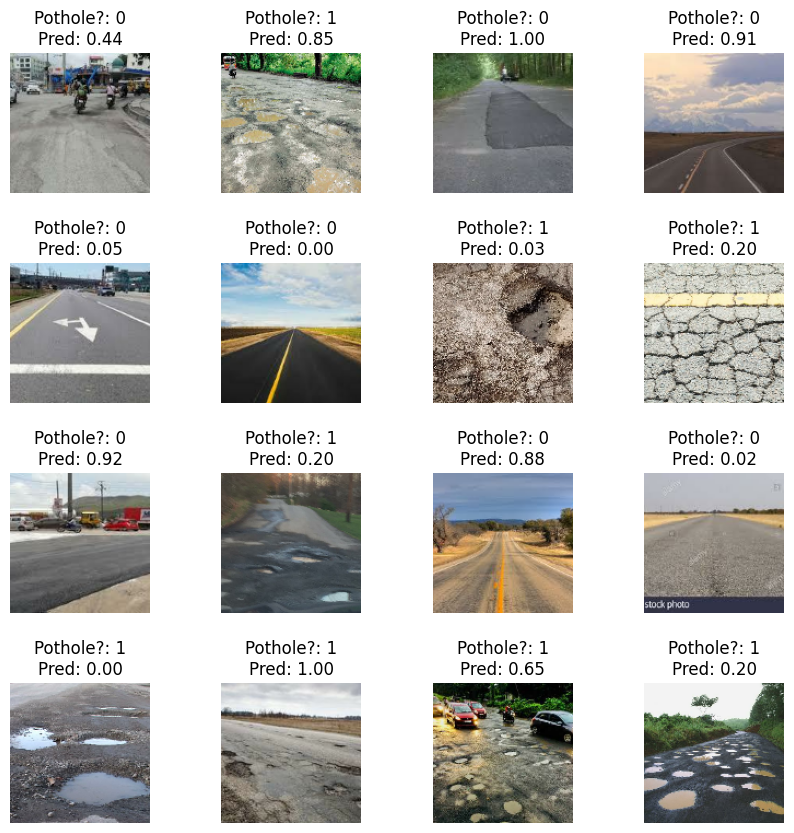

In [ ]:
# Use the trained model to predict on the test data
test_predictions = best_model.predict(ds_test)

# Print some test images with their respective predictions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, (image, label) in enumerate(ds_test.unbatch().take(16)):
    row, col = divmod(i, 4)
    axs[row][col].imshow(image.numpy().astype("uint8"))
    axs[row][col].set_title("Pothole?: {}\nPred: {:.2f}".format(int(label.numpy()), test_predictions[i][0]))
    axs[row][col].axis("off")

plt.show()

Optimizing our hyperparameters with Hyperband. This tuner randomly samples some combinations of hyperparameters and instead of running full training and evaluation on them, like with RandomSearch, it trains the model with these combinations only for a few epochs, selecting the best candidates. This is more efficient, saving time and computational resources. 

The HyperBand works by using to brakects, in the first bracket it trains 50  modelswith different parameters with 2 epochs and saves their results, in the last 8 trials it takes the best 8 and continues them until the 50 epoch.

In [ ]:
from kerastuner.tuners import Hyperband

# Build and train the model using the Hyperband tuner
tuner_HB = Hyperband(
    build_and_train_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=35,
    seed=42,
    directory='keras_tuner_dir',
    project_name='hyperparameter_search2'
)

tuner_HB.search_space_summary()

# Perform the search
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
tuner_HB.search(ds_train, validation_data=ds_val, epochs=50, callbacks=[early_stopping])

# Get the best hyperparameters
best_hyperparametersHB = tuner_HB.get_best_hyperparameters(num_trials=1)[0]



Trial 58 Complete [00h 08m 38s]
val_accuracy: 0.8850173950195312

Best val_accuracy So Far: 0.9616724848747253
Total elapsed time: 00h 49m 31s


In [ ]:
# Get the best hyperparameters
best_hyperparametersHB = tuner_HB.get_best_hyperparameters(num_trials=1)[0]

# Get the best model using the best hyperparameters
best_model_HB = tuner_HB.get_best_models(num_models=1)[0]


# Plot training and validation loss and accuracy using the custom function
tuner_HB.results_summary(num_trials=1)

# Evaluate the best model on the training dataset
train_loss, train_accuracy, train_AUROC = best_model_HB.evaluate(ds_train)
print("Training accuracy:", train_accuracy)
print("Training AUROC:", train_AUROC)
print("Training loss:", train_loss)

# Evaluate the best model on the validation dataset
val_loss, val_accuracy, val_AUROC = best_model_HB.evaluate(ds_val)
print("Validation accuracy:", val_accuracy)
print("Validation AUROC:", val_AUROC)
print("Validation loss:", val_loss)

Results summary
Results in keras_tuner_dir/hyperparameter_search2
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0055 summary
Hyperparameters:
num_conv_layers: 4
filters_layer_0: 32
dropout_rate_0: 0.15
filters_layer_1: 64
dropout_rate_1: 0.15
use_exp_decay: True
learning_rate: 0.01
filters_layer_2: 32
dropout_rate_2: 0.0
filters_layer_3: 32
dropout_rate_3: 0.3
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9616724848747253
18/18 [==============================] - 8s 176ms/step - loss: 0.2135 - accuracy: 0.9504 - AUROC: 0.9911
Training accuracy: 0.9503916501998901
Training AUROC: 0.9910502433776855
Training loss: 0.21351675689220428
5/5 [==============================] - 1s 255ms/step - loss: 0.2213 - accuracy: 0.9617 - AUROC: 0.9912
Validation accuracy: 0.9616724848747253
Validation AUROC: 0.9912408590316772
Validation loss: 0.2212572693824768


Now we used the best model we created to predict the test images and printed each one with the respective class (since our test data is very small we printed every image).

1/1 [==============================] - 0s 48ms/step


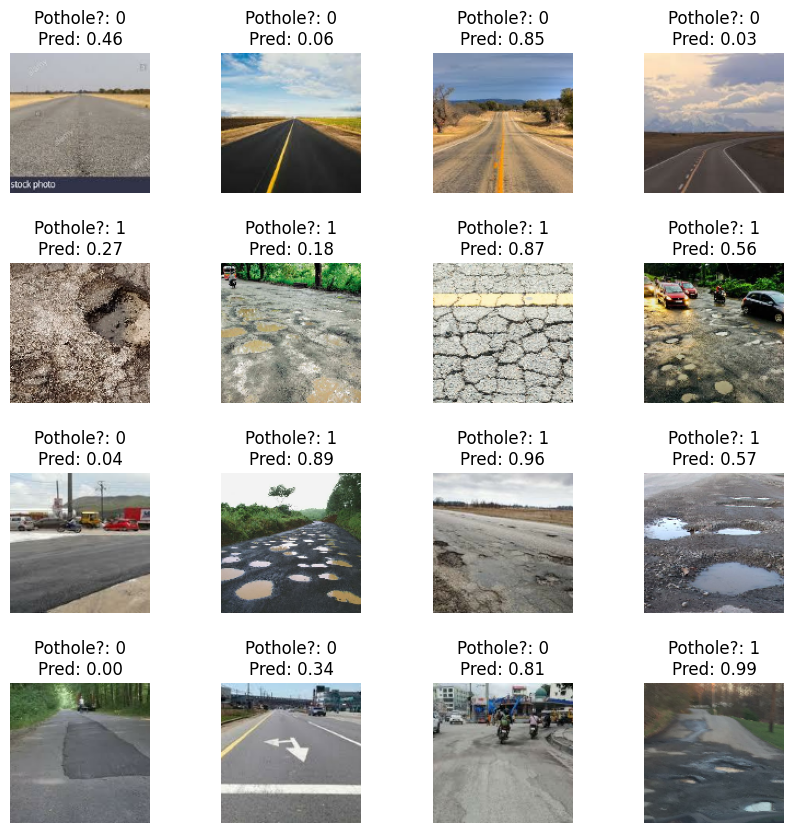

In [ ]:
# Use the trained model to predict on the test data
test_predictions = best_model_HB.predict(ds_test)

# Print some test images with their respective predictions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, (image, label) in enumerate(ds_test.unbatch().take(16)):
    row, col = divmod(i, 4)
    axs[row][col].imshow(image.numpy().astype("uint8"))
    axs[row][col].set_title("Pothole?: {}\nPred: {:.2f}".format(int(label.numpy()), test_predictions[i][0]))
    axs[row][col].axis("off")

plt.show()

## **Comparing the HandCraft last model, the RandomSearch model and HyperBand model**


| Model|  loss| accuracy | AUROC  | val_loss | val_accuracy | val_AUROC | Overfitting accuracy | Overfitting AUROC | Correct Images |
| :--- | :----: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| HandCraft | 0.1793 | 0.9339 | 0.9865 | 0.1771 | 0.9408 | 0.9893 | -0.0069 | 0.0028 | 7/8
| RandomSearch | 0.1348 | 0.9617 | 0.9956 | 0.2203 | 0.9442 | 0.9799 | 0.0175 | 0.0157 | 8/16
| HyperBand | 0.2135 | 0.9504 | 0.9910 | 0.2213 | 0.9617 | 0.9912 | -0.0113 | 0.0012| 12/16

According to the results, we can say that the RandomSearch method outperformed other models in terms of accuracy and AUROC scores during training and validation. Nevertheless, it displayed some underfitting. It's important to take into account that machine learning models are somewhat unpredictable. <br>
Both the HandCraft and HyperBand models have overfitting despite displaying good accuracy and AUROC scores.<br>
The Correct Images column is based on the test dataset, which was very small, therefore it is not ideal to compare the models effectively. 
